Данный файл генерирует файл main_control_set.txt с примитивами основного (который использовался в тексте диплома
и изображён на рис. 48) control set. По аналогии с этим кодом можно сгенерировать любые свои варианты control set
и использовать в последующих алгоритмах (они написаны очень универсально и могут работать с любыми примитивами - достаточно
подать им на вход файл с примитивами, генерирующийся в create_prims_file.py)

In [1]:
import matplotlib.pyplot as plt
from create_prims_file import save_and_show
from trajectory_optimization import optimization_Newton 

import sys
sys.path.append("../common/")
from KC_structs import *
from KC_graphics import *

# это позволяет рисовать прямо внутри jupyter notebook (а не в отдельном окне):
%matplotlib inline  

In [8]:
theta_16 = Theta()  # фиксируем дискретизацию на 16 направлений
primitives_file = "main_control_set.txt"  # файл, куда сохранять примитивы control set

### Генерируем control set

Control set - это набор примитивов из дискретных состояний вида $(0,0,\theta_l)$, где $l \in \{0,\ldots,15\}$ - номер дискретного направления. Каждый примитив - это короткая допустимая траектория между дискретными состояниями, которую можно генерировать
с помощью оптимизации многомерным методом Ньютона (как описано ранее).

Таким образом, генерировать каждый примитив control set будем следующим образом: выбираем начальное дискретное направление $\theta_l$, выбираем целевое дискретное состояние $(i_f,j_f,\theta_{l_f})$, генерируем короткую траекторию из $(0,0,\theta_l)$ в $(i_f,j_f,\theta_{l_f})$. Для упрощения можно генерировать один примитив, а потом размножить его просто поворотам на $\pi/2$, так как вполне логично считать, что, например, из дискретных углов $0, \pi/2, \pi/ 3\pi/2$ выходят одинаковые наборы примитив, отличающиеся только поворотами (но можно и по-другому генерировать набор control set, индивидуально выстраивая каждый примитив; как именно и в каком количестве генерировать примитивы решает каждый автор в зависимости от задачи и своих предпочтений; данный код сделан наиболее универсально, чтобы каждый пользователь мог быстро и просто получить набор control set лишь указав начальный дискретный уго и целевые состояния по аналогии с тем, как сделано далее).

Всё это время мы работаем на плоскости с координатами $(x,y)$, где $x$-ось направлена вправо, а $y$-ось направлена вверх. Дискретными координатами мы считаем просто целочисленные значения x и y и обозначаем, соответственно, $j$ и $i$ (при записи дискретных координат обычно пишут сначала номер строки, потом номер столбца, поэтому получается $(i,j)$ - то есть запись в обратном порядке, чем $(x,y)$, где $x$ по горизонтали, $y$ по вертикали). Таким образом, в рамках данной реализации генерации примитивов (и коротких траекторий вообще) мы считаем, что дискретные координаты $(i,j)$ - это просто подмножество (а именно - целочисленные значения) непрерывных координат $(x,y)$ и не более того. В частности, направление осей $i$ (вверх) и $j$ (вправо) такое же, как у $у$ и $x$ соответственно. И все функции в рамках генерации траекторий исходят из этого - так просто удобнее, например, для вычисления клеток коллизионного следа (для которых не нужно как-то переворачивать оси, достаточно просто округлить непрерывные $(x,y)$ до дискретных $(i,j)$). 

<details>
  <summary>Если вы всё же запутались с тем, почему тут $i$-ось направлена вверх, а в baseline-решении вниз, и как с этим совладать, нажмите на стрелочку для раскрытия большого блока поясняющего текста. </summary>
    <ol>
        Однако при поиске траекторий дискретные карты часто задаются матрицами, где нумерация по строкам идёт сверху вниз (то есть $i$-ось переворачивается). На самом деле это почти ни на что не влияет (так как вся теория - примитивы, поиск на state lattice, алгоритмы и тд - не привязаны ни к каким направлениям осей, в теории важно только то, что есть две координаты, однозначно задающие положение) и можно искать 
путь с помощью сгенерированных примитивов, и всё будет работать. Единственное, что поменяется - это восприятие углов направления: если обычно (например, в данном коде, когда генерируем примитивы на обычной плоскости $(x,y)$, где $y$-ось и $i$-ось направлены вверх), например, угол $45^{\circ}$ (отсчитывающийся от горизонтали против часовой стрелки) обозначает направление вверх-вправо (то есть при движении по примитиву из такого направления, значение $i$-координаты возрастает), то при перевёрнутой $i$-оси этот угол будет указывать вниз-вправо (ведь при движении по тому же самому примитиву из это угла, $i$-координата снова будет расти, но так как направление $i$-оси теперь вниз, то и движение по этому примитиву будет  происходить вниз..., то есть с точки зрения примитива ничего не поменяется - как по нему двигались, так и двигаются, но для стороннего наблюдателя это будут разные направления). В итоге, если при перевёрнутой $i$-оси использовать те примитивы, которые сгенерируем в данном коде, ничего не поменяется, просто с человеческой точки зрения будет непривычно, что, например, угол направления в начально состоянии положительный, но траектория на карте будет идти вниз.
        
В принципе, если поиск пути производится на карте просто в рамках тестирования или для реального агента, то как интерпретируются углы вообще не важно (роботу всё равно, как оси направлены, он будет двигаться так, как сгенерируется кривая - а итоговая траектория в любых координатах будет одна и та же, просто углы будут меняться по-разному, что для движения не имеет значения) и можно об этом вообще не задумываться и использовать примитивы как есть (так и поступим, например, в коде на C++, который будет заниматься тестирование и измерениями скорости нахождения траектории).

Если же хочется сгенерировать траекторию и посмотреть на результат на картинке, то чтобы с справиться с перевернутой $i$-осью, можно просто перевернуть все карты (отразив их от горизонтальной прямой), но это неудобно, так как тогда они потеряют свой облик и будут выглядеть вверх-ногами. Поэтому есть второй вариант - перевернуть все примитивы. Для этого не нужно вносить какие-то изменения ни в данный код при генерации траекторий, ни в код загрузки уже сгенерированных траекторий далее в разделе базового (baseline) решения. Достаточно просто перевернуть углы в начальном и конечном состояниях - вместо $\theta_l$ использовать $-\theta_l$.

Таким образом, при генерации примитивов считаем, что оси $i$ и $y$ вверх, а если при использовании на дискретной карте понадобится направить ось $i$ вниз, то просто интуитивно (то есть не внося никаких изменений в код) перевернём отсчёт углов: если захочется, чтобы мобильный агент двигался на карте вверх-вправо под углом $\theta_l$, то просто используем $-\theta_l$ и этого достаточно (заметим, что такое домножение на $-1$ достаточно сделать только для углов начального и конечного направлений (внутри примитивов ничего трогать не надо), так как это влияет только на человеческое восприятие, куда идёт траектория (<<вниз>> или <<вверх>>), а примитивам всё равно - они будут двигаться из заданного угла и менять в них ничего не надо).
    </ol> 
</details>

#### Генерируем прмитивы из дискретных направлений $~0,~~\pi/2, ~~\pi,~~ 3\pi/2$.

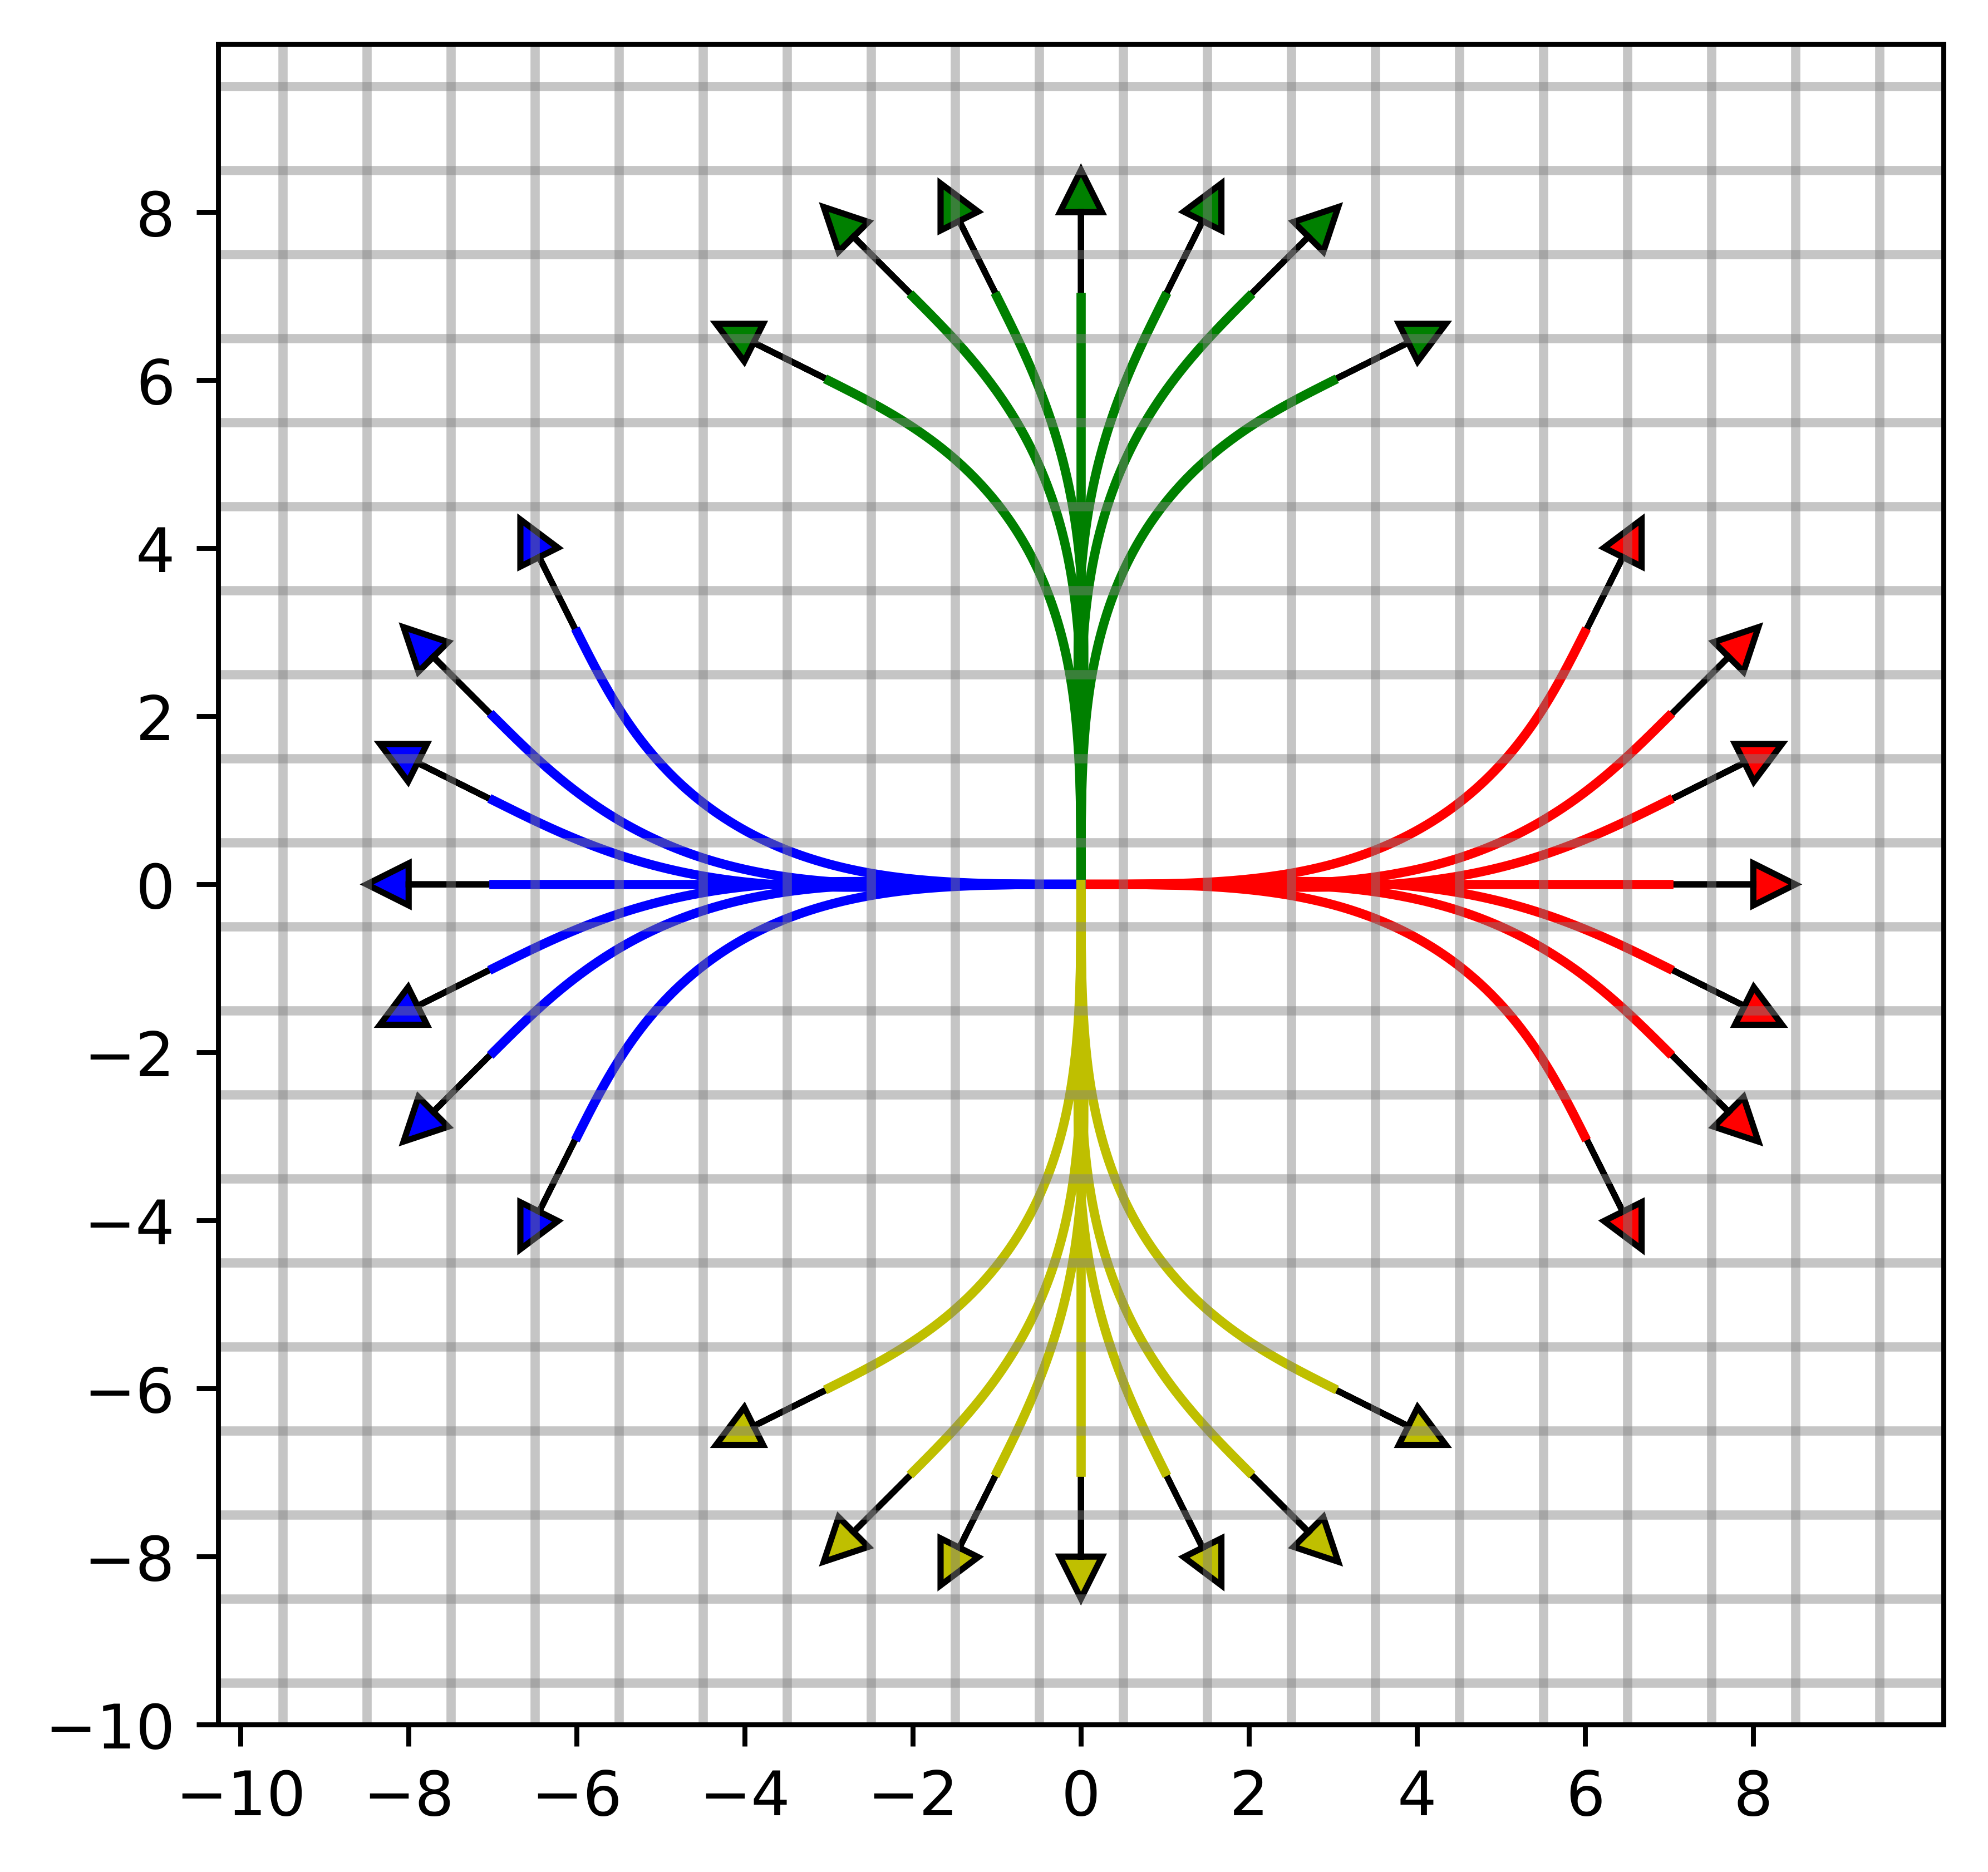

In [3]:
start = State(x=0, y=0, theta=theta_16[0])  # начальное дискретное состояние (для угла 0)
                                            # (используем класс State, а не DiscreteState, так как примитив - частный случай
                                            # короткой траектории, а для её генерации используется State... так как состояния нас интересуют
                                            # дискретные (примитив между ними), то при генерации примитивов в State подаём только целочисленные
                                            # x, y, а также theta = какое-то дискретное направление (получаем с помощью theta_16) и k = 0)

fig = plt.figure(figsize=(5, 5), dpi=800)  # готовим холст для рисования сгенерированных примитивов
ax = fig.add_subplot(111)

for target in [State(x=7.0, y=0.0, theta=theta_16[0]),  # из start генерируем ровно 7 примитивов в следующие дискретные состояния
               
               State(x=7.0, y=1.0, theta=theta_16[1]),
               State(x=7.0, y=2.0, theta=theta_16[2]),
               State(x=6.0, y=3.0, theta=theta_16[3]),
               
               State(x=7.0, y=-1.0, theta=theta_16[-1]),
               State(x=7.0, y=-2.0, theta=theta_16[-2]),
               State(x=6.0, y=-3.0, theta=theta_16[-3])]:
    
    prim = optimization_Newton(start=start, goal=target, show_animation=False)  # генерируем очередной примитив
    save_and_show(file=primitives_file, prim=prim, ax=ax, theta_discrete=theta_16)  # сохраняем его, а также сохраняем ещё три его повёрнутые версии (для углов pi/2, pi, 3pi/2)
                                                           # (в итоге всего в цикле сгенерируем 4 * 7 = 28 примитивов, по 7 для четырёх направлений с шагом pi/2)
                                                           # (таким образом, примитивы control set для направлений 0, pi/2, pi, 3pi/2 отличаются только поворотом)

draw_grid(ax, xs=-10, ys=-10, xf=10, yf=10, tick_step=2)  # рисуем grid - так выглядит дискретное рабочее пространство

#plt.savefig("control_set_1.png", transparent=False, facecolor='white')
plt.show()

In [4]:
from typing import Union
a = Union[int, float]

type(float)

type

#### Примитивы из направлений $~\pi/4,~~3\pi/4,~~5\pi/4,~~7\pi/4$

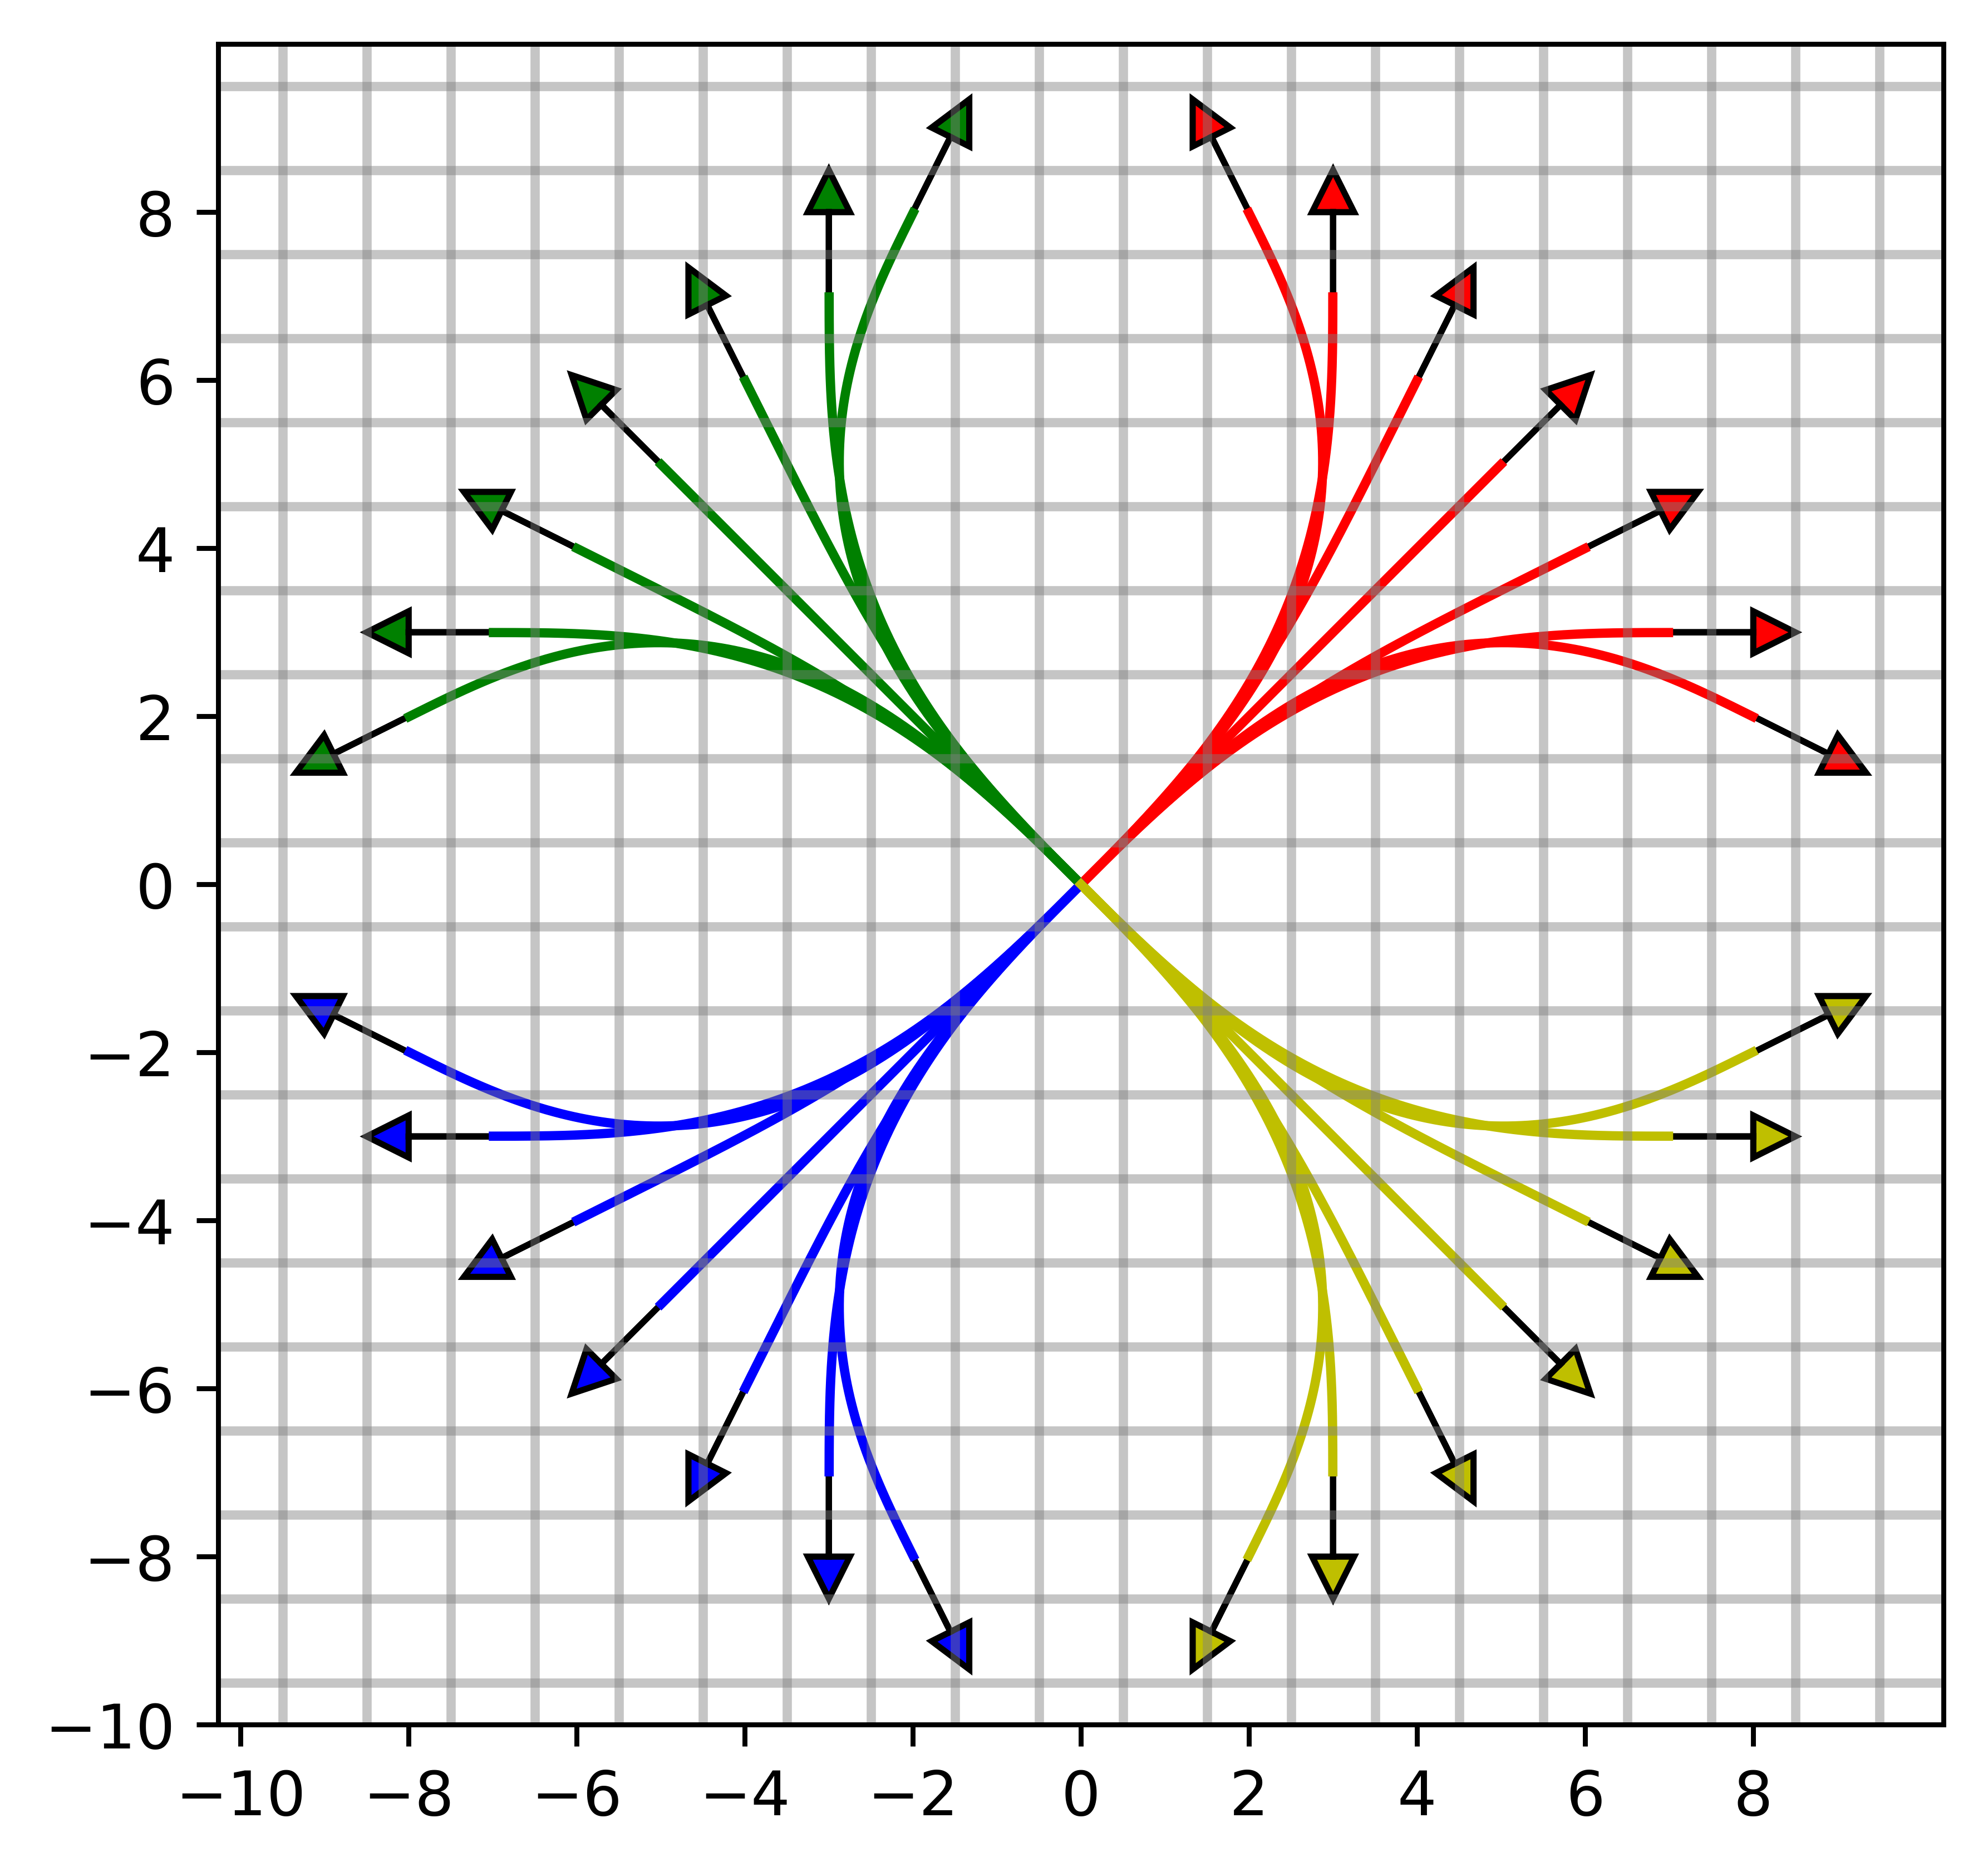

In [5]:
start = State(x=0, y=0, theta=theta_16[2])  # для угла 2

fig = plt.figure(figsize=(5, 5), dpi=800)
ax = fig.add_subplot(111)

for target in [State(x=5.0, y=5.0, theta=theta_16[2]),
               
               State(x=6.0, y=4.0, theta=theta_16[1]),
               State(x=7.0, y=3.0, theta=0),
               State(x=8.0, y=2.0, theta=theta_16[-1]),
               
               State(x=4.0, y=6.0, theta=theta_16[3]),
               State(x=3.0, y=7.0, theta=theta_16[4]),
               State(x=2.0, y=8.0, theta=theta_16[5])]:
    
    prim = optimization_Newton(start=start, goal=target, show_animation=False)
    save_and_show(file=primitives_file, prim=prim, ax=ax, theta_discrete=theta_16)

draw_grid(ax, xs=-10, ys=-10, xf=10, yf=10, tick_step=2)

#plt.savefig("control_set_2.png", transparent=False, facecolor='white')
plt.show()

#### Примитивы для оставшихся $8$-ми направлений control set

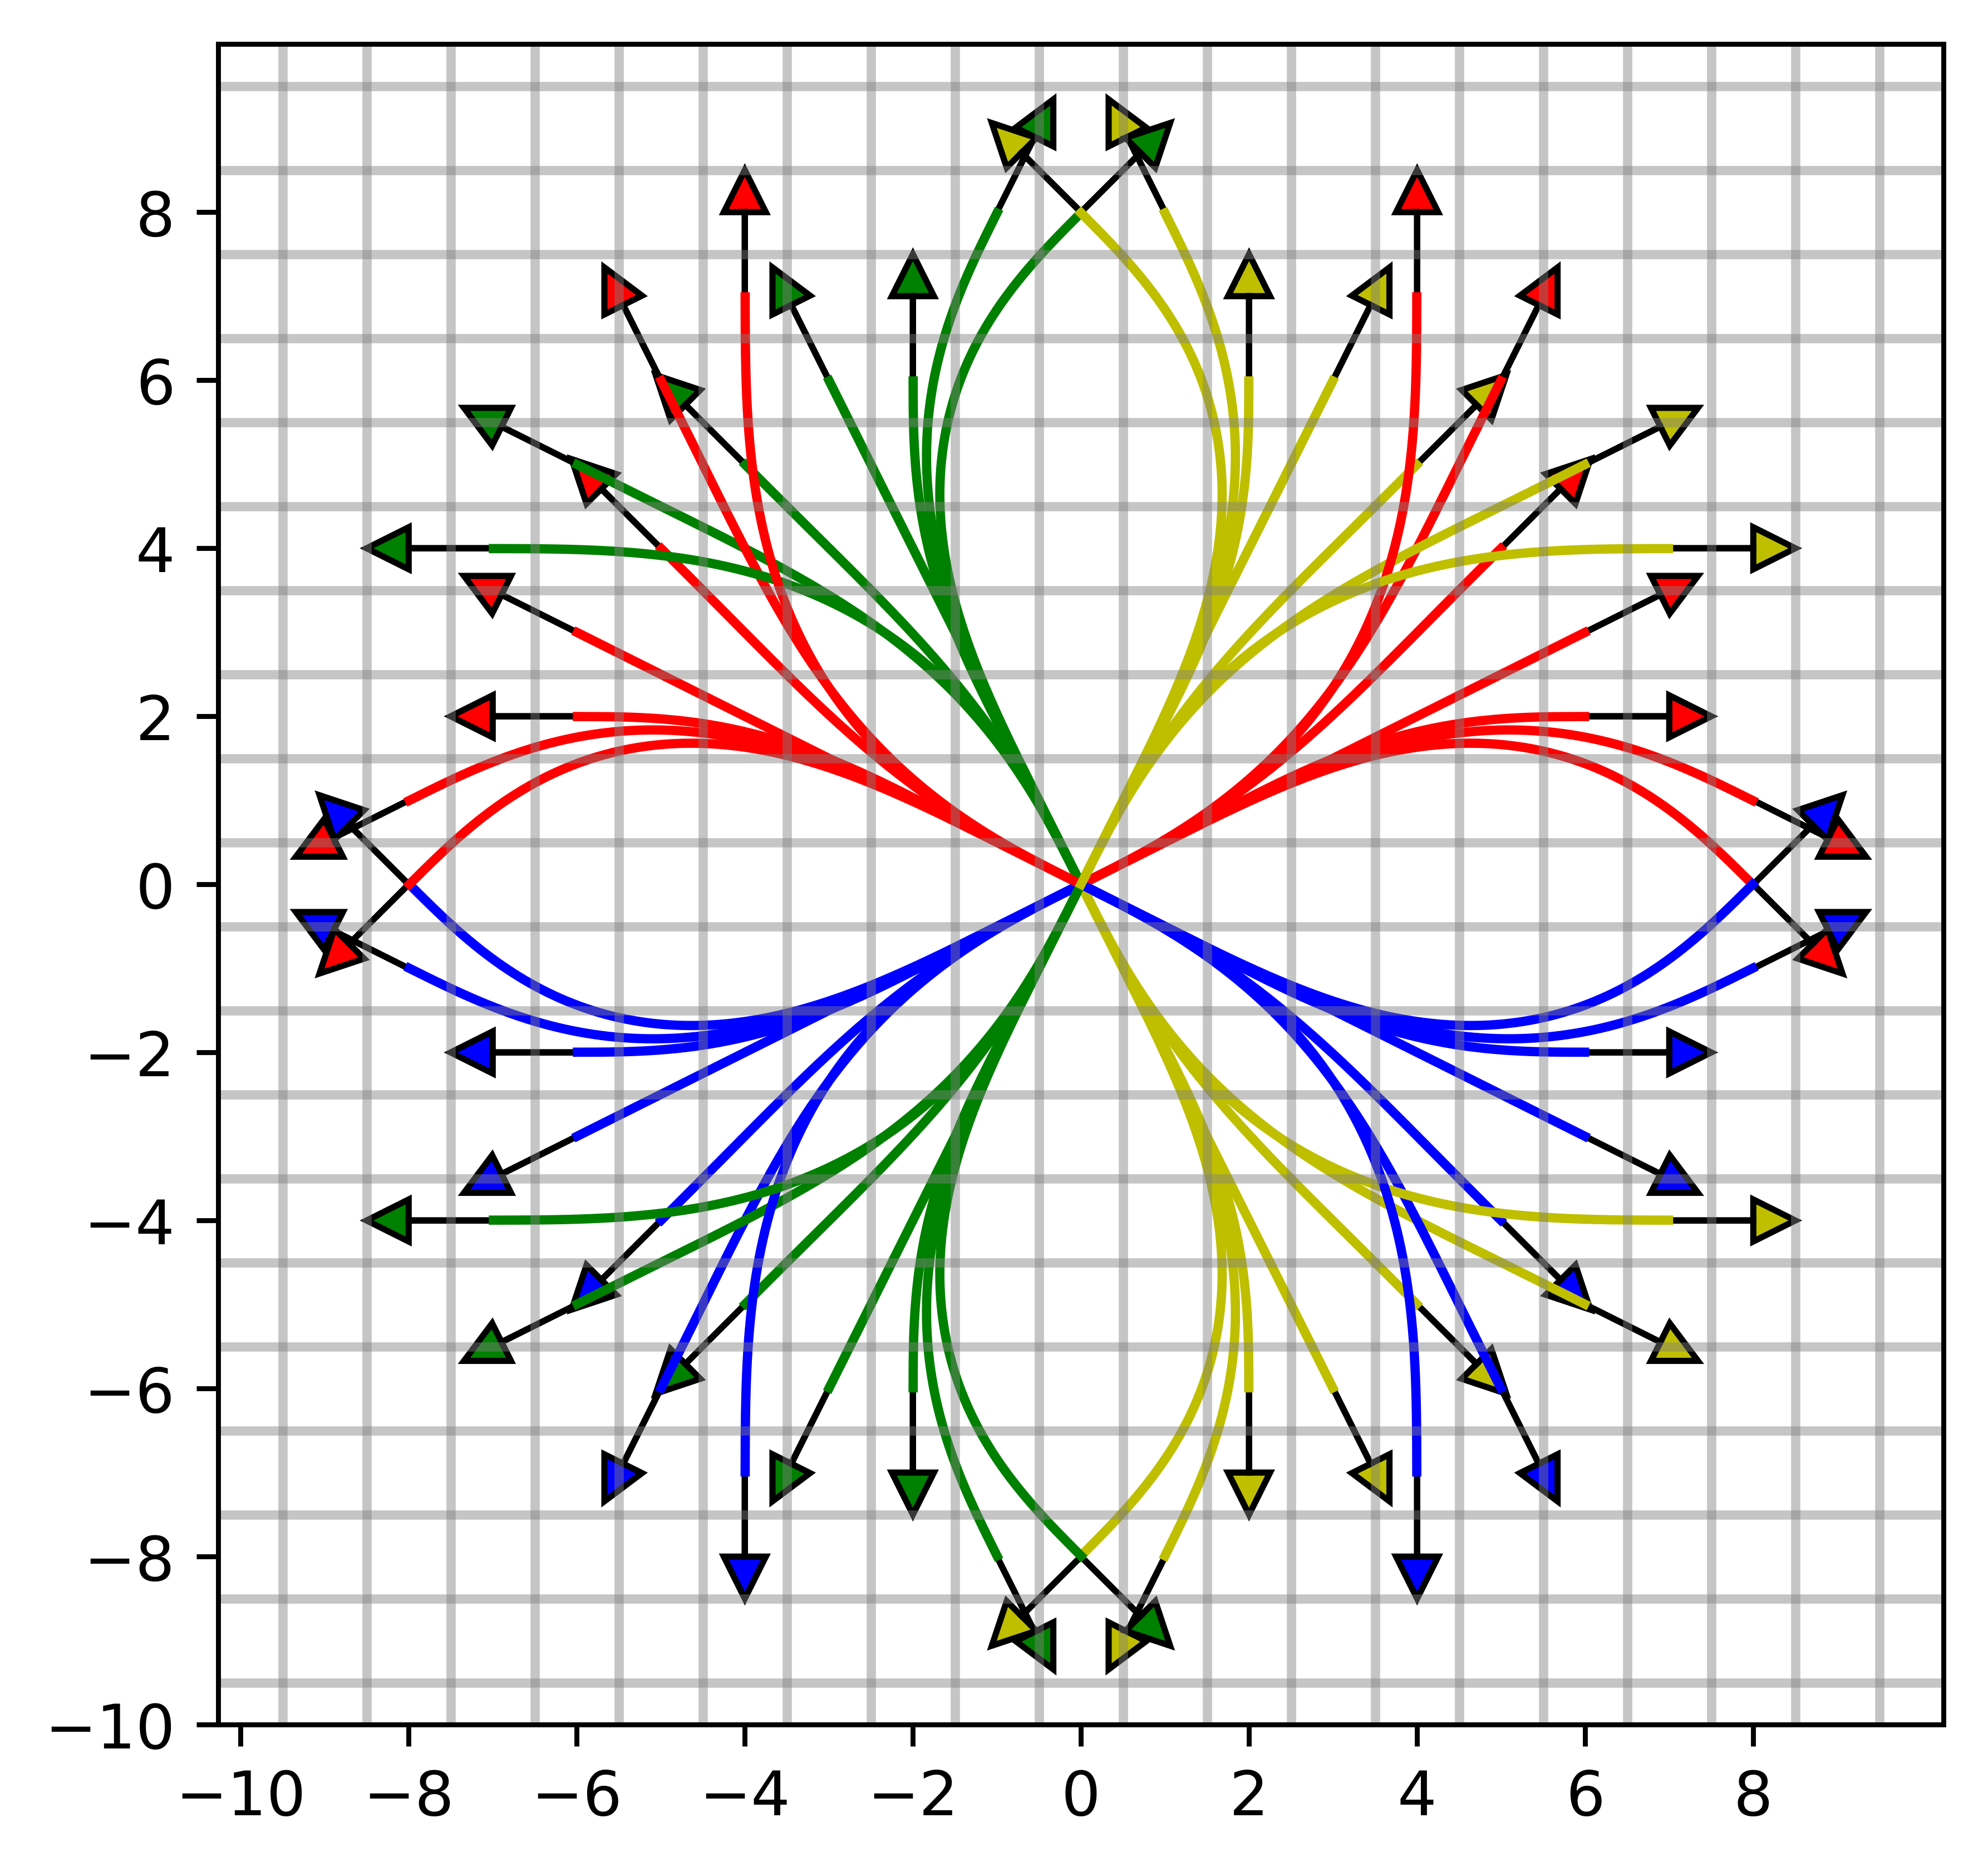

In [6]:
start = State(x=0, y=0, theta=theta_16[1])  # фиксируем дискретное направление = arctan(1/2)

fig = plt.figure(figsize=(5, 5), dpi=800)
ax = fig.add_subplot(111)

for target in [State(x=6.0, y=3.0, theta=theta_16[1]),  # перебираем конечные дискретные состояния
               
               State(x=6.0, y=2.0, theta=theta_16[0]),
               State(x=8.0, y=1.0, theta=theta_16[-1]),
               State(x=8.0, y=0.0, theta=theta_16[-2]),
         
               State(x=5.0, y=4.0, theta=theta_16[2]),
               State(x=5.0, y=6.0, theta=theta_16[3]),
               State(x=4.0, y=7.0, theta=theta_16[4])]:
    
    prim = optimization_Newton(start=start, goal=target, show_animation=False)  # генерируем очередной примитив
    save_and_show(file=primitives_file, prim=prim, ax=ax, theta_discrete=theta_16)  # сохраняем его (и три его повёрнутых копи с шагом \pi/2)
    
    # после сохранения отражаем относительно оси Y примитив и тоже сохраняем (тоже вместе с копиями с шагом \pi/2):
    prim.start = State(prim.start.x, prim.start.y, theta_16[7], -prim.k0)  # меняем начальный угол и симметрим кривизну
    prim.goal = State(-prim.goal.x, prim.goal.y, theta_16[7] - (prim.goal.theta - theta_16[1]))  # меняем конченое положение (симметрично от Y)
    prim.set_coef_params(-prim.a, -prim.b, -prim.c, prim.length)  # при симметрии примитив поворачивает в другую сторону ->
                                                                  # -> кривизна меняет знак -> все коэффициенты полиномиальной кривизны на -1
                                                                  # (а длина не меняется)
    save_and_show(file=primitives_file, prim=prim, ax=ax, theta_discrete=theta_16)

draw_grid(ax, xs=-10, ys=-10, xf=10, yf=10, tick_step=2)

#plt.savefig("control_set_3.png", transparent=False, facecolor='white')
plt.show()